# <h1> <font color="teal"> Importing Libraries : </font> </h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from collections import defaultdict
import pickle
from sklearn.metrics.pairwise import cosine_distances
from wordcloud import WordCloud
from scipy.spatial import distance

### <h1> <font color="teal"> Importing The Pre-Processed Files : </font> </h1> 

In [2]:
file_path_content = '/Users/mukesh/Documents/01-Dissertation/final/content.csv'
content = pd.read_csv(file_path_content)

In [3]:
file_path_movies = '/Users/mukesh/Documents/01-Dissertation/final/movies.csv'
movies = pd.read_csv(file_path_movies)

In [4]:
file_path_ratings = '/Users/mukesh/Documents/01-Dissertation/final/ratings.csv'
ratings = pd.read_csv(file_path_ratings)

In [5]:
file_path_genres_features_scaled = '/Users/mukesh/Documents/01-Dissertation/final/genres_features_scaled.npy'
genres_features_scaled = np.load(file_path_genres_features_scaled)

In [6]:
file_path_weighted_features = '/Users/mukesh/Documents/01-Dissertation/final/weighted_features.npy'
weighted_features = np.load(file_path_weighted_features)

In [7]:
file_path_user_movie = '/Users/mukesh/Documents/01-Dissertation/final/user_movie.csv'
user_movie = pd.read_csv(file_path_user_movie, index_col=0)

In [8]:
file_path_user_similarity_matrix = '/Users/mukesh/Documents/01-Dissertation/final/user_similarity_matrix.csv'
user_similarity_matrix = pd.read_csv(file_path_user_similarity_matrix, index_col=0)

#   <h1> <font color="teal"> Content Based Filtering :</font> </h1> 

In [9]:
nn_content = NearestNeighbors(n_neighbors=100, metric='cosine')
nn_content.fit(pd.DataFrame(weighted_features))

NearestNeighbors(metric='cosine', n_neighbors=100)

In [10]:
def find_idx_by_title(title):
    idx = movies[movies['title'] == title].index
    if len(idx) > 0:
        return idx[0]
    else:
        return None

In [11]:
def recommend_movies(movie_idx, features, model):
    if features.shape != (1, 19):
        raise ValueError(f"Expected features shape (1, 19), but got {features.shape}")
    distances, indices = model.kneighbors(features)
    recommended_movies = pd.DataFrame([movies.iloc[idx] for idx in indices.flatten()])
    recommended_movies['distance'] = distances.flatten()
    return recommended_movies.drop(movie_idx)

In [12]:
class ContentBasedModel:

    def recommend(self, movie_title):
        movie_index = find_idx_by_title(movie_title)
        if movie_index is None:
            return []

        features_array = np.array(weighted_features[movie_index])

        if len(features_array.shape) == 2:
            features_df = pd.DataFrame(features_array)
        else:
            features_df = pd.DataFrame(features_array).transpose()

        recommendations = recommend_movies(movie_index, features_df, nn_content)
        return recommendations

In [13]:
class Colors:
    HEADER = '\033[95m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

def print_recommendations(model_name, recommendations, title_to_id_dict, num_movies=30):
    print(f"{Colors.HEADER}{Colors.BOLD}{Colors.UNDERLINE}{'='*10} {model_name} Recommendations {'='*10}{Colors.END}\n")
    for idx, (_, rec) in enumerate(recommendations.iterrows(), 1):
        if idx > num_movies:
            break
        movie_id = title_to_id_dict.get(rec['title'], "Unknown ID")
        distance_score = rec.get('distance', None)
        if distance_score is not None:
            print(f"{Colors.GREEN}{idx}. {Colors.BLUE}{rec['title']} {Colors.YELLOW}(Movie ID: {movie_id}) {Colors.RED}Distance Score: {distance_score:.4f}{Colors.END}")
        else:
            print(f"{Colors.GREEN}{idx}. {Colors.BLUE}{rec['title']} {Colors.YELLOW}(Movie ID: {movie_id}){Colors.END}")
    print("\n")

In [14]:
content_model = ContentBasedModel()

movie_title = "Toy Story (1995)"
content_recommendations = content_model.recommend(movie_title)
title_to_id = dict(zip(movies['title'], movies['movieId']))
content_rec = content_recommendations[['movieId', 'title', 'genres', 'year']]
print_recommendations("Content-Based", content_recommendations, title_to_id)

========== Content-Based Recommendations ==========

1. Antz (1998) (Movie ID: 2294) Distance Score: 0.0000
2. Aladdin (1992) (Movie ID: 114240) Distance Score: 0.0000
3. Toy Story 2 (1999) (Movie ID: 3114) Distance Score: 0.0000
4. Emperor's New Groove, The (2000) (Movie ID: 4016) Distance Score: 0.0000
5. Adventures of Rocky and Bullwinkle, The (2000) (Movie ID: 3754) Distance Score: 0.0000
6. DuckTales: The Movie - Treasure of the Lost Lamp (1990) (Movie ID: 33463) Distance Score: 0.0000
7. Monsters, Inc. (2001) (Movie ID: 4886) Distance Score: 0.0000
8. Asterix and the Vikings (Astérix et les Vikings) (2006) (Movie ID: 91355) Distance Score: 0.0000
9. Brother Bear 2 (2006) (Movie ID: 131248) Distance Score: 0.0000
10. Wild, The (2006) (Movie ID: 45074) Distance Score: 0.0000
11. Shrek the Third (2007) (Movie ID: 53121) Distance Score: 0.0000
12. Tale of Despereaux, The (2008) (Movie ID: 65577) Distance Score: 0.0000
13. Toy Story Toons: Small Fry (2011) (Movie ID: 115879) Distance 

In [15]:
content_rec.head(20)

,movieId,title,genres,year
2203,2294,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy,1998
22285,114240,Aladdin (1992),Adventure|Animation|Children|Comedy|Fantasy,1992
3021,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,1999
3912,4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,2000
3653,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,2000
9949,33463,DuckTales: The Movie - Treasure of the Lost La...,Adventure|Animation|Children|Comedy|Fantasy,1990
4780,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,2001
17430,91355,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy,2006
28227,131248,Brother Bear 2 (2006),Adventure|Animation|Children|Comedy|Fantasy,2006
10773,45074,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy,2006


# <h1> <font color="teal"> Collaborative Based Filtering :</font> </h1> 

In [16]:
def user_similarity_using_cosine(user_movie):
    distances = cosine_distances(user_movie)
    return distances

In [17]:
def get_user_ratings(user_id):
    user_ratings = ratings[ratings['userId'] == user_id]
    return user_ratings

In [18]:
def calculate_distances(user_id, similar_users):
    user_ratings_dict = {}
    ratings_per_user = get_user_ratings(user_id)
    for index, row in ratings_per_user.iterrows():
        movie_id = int(row['movieId'])
        rating = row['rating']
        user_ratings_dict[movie_id] = rating
    distances = defaultdict(float)
    for similar_user_id, similarity_score in similar_users.items():
        distance = 1 - similarity_score
        similar_user_ratings = get_user_ratings(similar_user_id)
        for index, similar_user_rating in similar_user_ratings.iterrows():
            movie_id = similar_user_rating['movieId']
            similar_user_rating = similar_user_rating['rating']
            if movie_id not in user_ratings_dict:
                distances[movie_id] += (similar_user_rating / 5.0) * distance
    return distances

In [19]:
def get_top_similar_users(user_id, user_similarity_matrix, n=100):
    user_similarity_scores = user_similarity_matrix.loc[user_id, :]
    sorted_scores = user_similarity_scores.sort_values(ascending=False)
    similar_users = sorted_scores.head(n)
    return similar_users

In [20]:
def get_top_collaborative_recommendations(distances, rated_movies, N=100):
    sorted_distances = sorted(distances.items(), key=lambda x: x[1], reverse=True)
    top_recommendations = []
    for movie_id, distance in sorted_distances:
        if movie_id in rated_movies: 
            continue
        if len(top_recommendations) >= N:
            break
        movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
        top_recommendations.append({'title': movie_title, 'distance': distance})
    return top_recommendations

In [21]:
class CollaborativeFilteringModel:
    def __init__(self):
        self.user_similarity_matrix = user_similarity_matrix

    def fit(self, user_movie_ratings):
        user_similarity_matrix = user_similarity_using_cosine(user_movie_ratings)
        np.fill_diagonal(user_similarity_matrix, 0)
        self.user_similarity_matrix = pd.DataFrame(user_similarity_matrix, index=user_movie_ratings.index, columns=user_movie_ratings.index)
        
    def recommend(self, user_id):
        user_ratings = get_user_ratings(user_id)
        user_ratings_dict = {movie_id: rating for movie_id, rating in zip(user_ratings['movieId'], user_ratings['rating'])}
        similar_users = get_top_similar_users(user_id, self.user_similarity_matrix)
        distances = calculate_distances(user_id, similar_users)
        rated_movies = list(user_ratings_dict.keys())
        already_watched = list(user_ratings_dict.keys())
        distances = {movie_id: distance for movie_id, distance in distances.items() if movie_id not in rated_movies and movie_id not in already_watched}
        top_collaborative_recommendations = get_top_collaborative_recommendations(distances, rated_movies, N=100)
        return top_collaborative_recommendations

In [22]:
collab_model = CollaborativeFilteringModel()
collab_model.fit(user_movie)

user_id = 847
collab_recommendations = collab_model.recommend(user_id)

title_to_id = dict(zip(movies['title'], movies['movieId']))

collab_recommendations_df = pd.DataFrame(collab_recommendations)
collab_rec = pd.merge(collab_recommendations_df[['title']], movies[['movieId', 'title', 'genres', 'year']], on='title', how='left')
print_recommendations("Collaborative Filtering", collab_recommendations_df, title_to_id)

========== Collaborative Filtering Recommendations ==========

1. Avengers, The (2012) (Movie ID: 89745) Distance Score: 18.1269
2. Guardians of the Galaxy (2014) (Movie ID: 112852) Distance Score: 17.7642
3. The Hunger Games (2012) (Movie ID: 91500) Distance Score: 17.1773
4. Pirates of the Caribbean: Dead Man's Chest (2006) (Movie ID: 45722) Distance Score: 17.0689
5. Thor (2011) (Movie ID: 86332) Distance Score: 17.0060
6. Fifth Element, The (1997) (Movie ID: 1527) Distance Score: 16.9297
7. Iron Man 2 (2010) (Movie ID: 77561) Distance Score: 16.8967
8. V for Vendetta (2006) (Movie ID: 44191) Distance Score: 16.6625
9. I, Robot (2004) (Movie ID: 8644) Distance Score: 16.6528
10. Zombieland (2009) (Movie ID: 71535) Distance Score: 16.5649
11. Transformers (2007) (Movie ID: 53996) Distance Score: 16.3794
12. Deadpool (2016) (Movie ID: 122904) Distance Score: 16.3102
13. Now You See Me (2013) (Movie ID: 102903) Distance Score: 16.2736
14. Captain America: The First Avenger (2011) (Movi

In [23]:
collab_rec.head(20)

,title,movieId,genres,year
0,"Avengers, The (2012)",89745,Action|Adventure|Sci-Fi|IMAX,2012
1,Guardians of the Galaxy (2014),112852,Action|Adventure|Sci-Fi,2014
2,The Hunger Games (2012),91500,Action|Adventure|Drama|Sci-Fi|Thriller,2012
3,Pirates of the Caribbean: Dead Man's Chest (2006),45722,Action|Adventure|Fantasy,2006
4,Thor (2011),86332,Action|Adventure|Drama|Fantasy|IMAX,2011
5,"Fifth Element, The (1997)",1527,Action|Adventure|Comedy|Sci-Fi,1997
6,Iron Man 2 (2010),77561,Action|Adventure|Sci-Fi|Thriller|IMAX,2010
7,V for Vendetta (2006),44191,Action|Sci-Fi|Thriller|IMAX,2006
8,"I, Robot (2004)",8644,Action|Adventure|Sci-Fi|Thriller,2004
9,Zombieland (2009),71535,Action|Comedy|Horror,2009


# <h1> <font color="teal"> Hybrid Model - 1 :</font> </h1> 

In [24]:
class HybridModel(BaseEstimator):
    def __init__(self, content_model, collab_model):
        self.content_model = content_model
        self.collab_model = collab_model

    def recommend(self, user_id, movie_title):
        try:
            if user_id not in user_similarity_matrix.index:
                print("User ID", user_id, "not found in similarity matrix. Skipping...")
                return []
            
            collaborative_recommendations = self.collab_model.recommend(user_id)
            content_recommendations = [{'title': rec[1]['title'], 'distance': rec[1]['distance']} for rec in self.content_model.recommend(movie_title).iterrows()]
            
            combined_recommendations = collaborative_recommendations + content_recommendations
            combined_recommendations = sorted(combined_recommendations, key=lambda x: x['distance'])
            
            return combined_recommendations
        except Exception as e:
            print(f"An error occurred for User ID {user_id}: {e}")
            return []

    def get_params(self, deep=True):
        return {'content_model': self.content_model, 'collab_model': self.collab_model}

    def set_params(self, **params):
        if 'content_model' in params:
            self.content_model = params['content_model']
        if 'collab_model' in params:
            self.collab_model = params['collab_model']
        return self

In [25]:
hybrid_model = HybridModel(content_model, collab_model)

user_id = 847
movie_title = "Toy Story (1995)"
hybrid_recommendations = hybrid_model.recommend(user_id, movie_title)

hybrid_recommendations_df = pd.DataFrame(hybrid_recommendations)

title_to_id = dict(zip(movies['title'], movies['movieId']))
rec1 = pd.merge(hybrid_recommendations_df[['title']], movies[['movieId', 'title', 'genres', 'year']], on='title', how='left')

print_recommendations("Hybrid Model", hybrid_recommendations_df, title_to_id)

========== Hybrid Model Recommendations ==========

1. Antz (1998) (Movie ID: 2294) Distance Score: 0.0000
2. Aladdin (1992) (Movie ID: 114240) Distance Score: 0.0000
3. Toy Story 2 (1999) (Movie ID: 3114) Distance Score: 0.0000
4. Emperor's New Groove, The (2000) (Movie ID: 4016) Distance Score: 0.0000
5. Adventures of Rocky and Bullwinkle, The (2000) (Movie ID: 3754) Distance Score: 0.0000
6. DuckTales: The Movie - Treasure of the Lost Lamp (1990) (Movie ID: 33463) Distance Score: 0.0000
7. Monsters, Inc. (2001) (Movie ID: 4886) Distance Score: 0.0000
8. Asterix and the Vikings (Astérix et les Vikings) (2006) (Movie ID: 91355) Distance Score: 0.0000
9. Brother Bear 2 (2006) (Movie ID: 131248) Distance Score: 0.0000
10. Wild, The (2006) (Movie ID: 45074) Distance Score: 0.0000
11. Shrek the Third (2007) (Movie ID: 53121) Distance Score: 0.0000
12. Tale of Despereaux, The (2008) (Movie ID: 65577) Distance Score: 0.0000
13. Toy Story Toons: Small Fry (2011) (Movie ID: 115879) Distance S

In [26]:
rec1.head(20)

,title,movieId,genres,year
0,Antz (1998),2294,Adventure|Animation|Children|Comedy|Fantasy,1998
1,Aladdin (1992),588,Adventure|Animation|Children|Comedy|Musical,1992
2,Aladdin (1992),114240,Adventure|Animation|Children|Comedy|Fantasy,1992
3,Toy Story 2 (1999),3114,Adventure|Animation|Children|Comedy|Fantasy,1999
4,"Emperor's New Groove, The (2000)",4016,Adventure|Animation|Children|Comedy|Fantasy,2000
5,"Adventures of Rocky and Bullwinkle, The (2000)",3754,Adventure|Animation|Children|Comedy|Fantasy,2000
6,DuckTales: The Movie - Treasure of the Lost La...,33463,Adventure|Animation|Children|Comedy|Fantasy,1990
7,"Monsters, Inc. (2001)",4886,Adventure|Animation|Children|Comedy|Fantasy,2001
8,Asterix and the Vikings (Astérix et les Viking...,91355,Adventure|Animation|Children|Comedy|Fantasy,2006
9,Brother Bear 2 (2006),131248,Adventure|Animation|Children|Comedy|Fantasy,2006


# <h1> <font color="teal"> Hybrid Model - 2 :</font> </h1> 

In [27]:
class HybridModel2(BaseEstimator):
    def __init__(self, content_model, collaborative_model, main_movie_dataset):
        self.content_model = content_model
        self.collaborative_model = collab_model
        self.main_movie_dataset = main_movie_dataset
        self.genre_columns = [col for col in main_movie_dataset.columns if col not in ['movieId', 'title', 'year', 'distance', 'distancescore']] 

    def recommend(self, user_id, movie_title, top_n=100):
        content_recommendations = self.content_model.recommend(movie_title)  
        collaborative_recommendations = self.collaborative_model.recommend(user_id)
        collaborative_recommendations = pd.DataFrame(collaborative_recommendations)
        content_recommendations = content_recommendations[['title', 'distance']].merge(self.main_movie_dataset[['title', 'movieId', 'genres']], on='title', how='left')
        collaborative_recommendations = collaborative_recommendations[['title', 'distance']].merge(self.main_movie_dataset[['title', 'movieId', 'genres']], on='title', how='left')
        combined_recommendations = self._merge_recommendations(content_recommendations, collaborative_recommendations)
        combined_recommendations = self.add_serendipity(combined_recommendations)
        combined_recommendations = self.ensure_diversity(combined_recommendations)
        combined_recommendations = self.MMR(combined_recommendations)  
        return combined_recommendations[['title', 'movieId', 'genres', 'distance']].head(top_n)


    def _merge_recommendations(self, recs1, recs2):
        merged_recommendations = pd.concat([recs1, recs2]).groupby('title').agg({'distance': 'mean'}).reset_index()
        merged_recommendations = self.main_movie_dataset[['title', 'movieId', 'genres']].merge(merged_recommendations, on='title', how='inner')
        return merged_recommendations



    def add_serendipity(self, recommendations, serendipity_percentage=0.2):
        num_replace = int(len(recommendations) * serendipity_percentage)
        movies_to_replace = recommendations.sample(num_replace)
        movies = self.main_movie_dataset['title'].values  
        not_recommended = [movie for movie in movies if movie not in recommendations['title'].values]
        replace_with_titles = np.random.choice(not_recommended, size=num_replace, replace=False)
        replace_with = self.main_movie_dataset[self.main_movie_dataset['title'].isin(replace_with_titles)][['title', 'movieId', 'genres']]
        recommendations = recommendations[~recommendations['title'].isin(movies_to_replace['title'])]
        recommendations = pd.concat([recommendations, replace_with], ignore_index=True)
        return recommendations

    def ensure_diversity(self, recommendations, threshold=0.7):
        all_genres = recommendations['genres'].str.split('|', expand=True).stack().reset_index(drop=True)
        genre_counts = all_genres.value_counts()
        if genre_counts.empty:
            return recommendations
        most_common_genre = genre_counts.idxmax()
        if genre_counts[most_common_genre] / len(recommendations) > threshold:
            dominating_movies = recommendations[recommendations['genres'].str.contains(most_common_genre)]
            recommendations = recommendations[~recommendations['genres'].str.contains(most_common_genre)]
            recommendations = pd.concat([recommendations, dominating_movies]).drop_duplicates().reset_index(drop=True)
        return recommendations

    def MMR(self, recommendations, beta=0.2):
        set1 = recommendations[:len(recommendations)//2]
        set2 = recommendations[len(recommendations)//2:]
        mmr_ranked = []
        while not set1.empty or not set2.empty:
            if not set1.empty:
                mmr_ranked.append(set1.iloc[0])
                set1 = set1.iloc[1:]
            if not set2.empty:
                mmr_ranked.append(set2.iloc[0])
                set2 = set2.iloc[1:]
        mmr_ranked_df = pd.DataFrame(mmr_ranked)
        return mmr_ranked_df

In [28]:
hybrid_model2 = HybridModel2(content_model, collab_model, movies)

user_id = 847
movie_title = "Toy Story (1995)"
recommendations_2 = hybrid_model2.recommend(user_id, movie_title)

title_to_id = dict(zip(movies['title'], movies['movieId']))

rec2 = pd.merge(recommendations_2[['title']], movies[['movieId', 'title', 'genres', 'year']], on='title', how='left')


print_recommendations("Hybrid Model 2", recommendations_2, title_to_id)

========== Hybrid Model 2 Recommendations ==========

1. Mask, The (1994) (Movie ID: 367) Distance Score: 14.3830
2. Pagemaster, The (1994) (Movie ID: 558) Distance Score: 0.0000
3. Fifth Element, The (1997) (Movie ID: 1527) Distance Score: 16.9297
4. Watership Down (1978) (Movie ID: 2138) Distance Score: 0.0000
5. Rush Hour (1998) (Movie ID: 2273) Distance Score: 12.5686
6. American Pie (1999) (Movie ID: 2706) Distance Score: 12.7769
7. Toy Story 2 (1999) (Movie ID: 3114) Distance Score: 0.0000
8. We're Back! A Dinosaur's Story (1993) (Movie ID: 3400) Distance Score: 0.0000
9. Emperor's New Groove, The (2000) (Movie ID: 4016) Distance Score: 0.0000
10. Mummy Returns, The (2001) (Movie ID: 4270) Distance Score: 13.9448
11. Shrek (2001) (Movie ID: 4306) Distance Score: 0.0000
12. Atlantis: The Lost Empire (2001) (Movie ID: 4366) Distance Score: 0.0000
13. Fast and the Furious, The (2001) (Movie ID: 4369) Distance Score: 13.6126
14. Land Before Time, The (1988) (Movie ID: 4519) Distance 

In [29]:
rec2.head(20)

,title,movieId,genres,year
0,"Mask, The (1994)",367,Action|Comedy|Crime|Fantasy,1994
1,"Pagemaster, The (1994)",558,Action|Adventure|Animation|Children|Fantasy,1994
2,"Fifth Element, The (1997)",1527,Action|Adventure|Comedy|Sci-Fi,1997
3,Watership Down (1978),2138,Adventure|Animation|Children|Drama|Fantasy,1978
4,Rush Hour (1998),2273,Action|Comedy|Crime|Thriller,1998
5,American Pie (1999),2706,Comedy|Romance,1999
6,Toy Story 2 (1999),3114,Adventure|Animation|Children|Comedy|Fantasy,1999
7,We're Back! A Dinosaur's Story (1993),3400,Adventure|Animation|Children|Fantasy,1993
8,"Emperor's New Groove, The (2000)",4016,Adventure|Animation|Children|Comedy|Fantasy,2000
9,"Mummy Returns, The (2001)",4270,Action|Adventure|Comedy|Thriller,2001


# <h1> <font color="teal"> Singular Value Decomposition (SVD) :</font> </h1> 

In [30]:
with open('svd_model.pkl', 'rb') as model_file:
    svd_model = pickle.load(model_file)

# <h1> <font color="teal"> SVD Hybrid Model-1 :</font> </h1> 

In [31]:
def get_svd_recommendations(user_id, n=100):

    all_movie_ids = ratings['movieId'].unique()

    rated_movie_ids = ratings[ratings['userId'] == user_id]['movieId'].tolist()

    unrated_movie_ids = [mid for mid in all_movie_ids if mid not in rated_movie_ids]
    
    predicted_ratings = []
    for movie_id in unrated_movie_ids:
        pred_rating = svd_model.predict(user_id, movie_id).est
        predicted_ratings.append((movie_id, pred_rating))

    recommended_movie_ids = sorted(predicted_ratings, key=lambda x: x[1], reverse=True)[:n]
    recommended_movie_ids = [x[0] for x in recommended_movie_ids]
    
    recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)][['movieId', 'title', 'genres']]
    return recommended_movies

In [32]:
class HybridModelSVD(BaseEstimator):
    def __init__(self, content_model, svd_model, main_movie_dataset):
        self.content_model = content_model
        self.svd_model = svd_model
        self.main_movie_dataset = main_movie_dataset

    def recommend(self, user_id, movie_title, top_n=100):
        content_recommendations = self.content_model.recommend(movie_title)
        svd_recommendations = get_svd_recommendations(user_id, top_n)
        
        combined_recommendations = pd.concat([content_recommendations[['movieId', 'title', 'genres']], svd_recommendations[['movieId', 'title', 'genres']]])
        combined_recommendations.drop_duplicates(subset='movieId', keep='first', inplace=True)
        return combined_recommendations[['movieId', 'title', 'genres']].head(top_n)

In [33]:
hybrid_model_svd = HybridModelSVD(content_model, svd_model, movies)

user_id = 847
movie_title = "Toy Story (1995)"
recommendations_svd = hybrid_model_svd.recommend(user_id, movie_title)
rec3 = pd.merge(recommendations_svd[['title']], movies[['movieId', 'title', 'genres', 'year']], on='title', how='left')

print_recommendations("Hybrid Model with SVD", recommendations_svd, title_to_id)

========== Hybrid Model with SVD Recommendations ==========

1. Antz (1998) (Movie ID: 2294)
2. Aladdin (1992) (Movie ID: 114240)
3. Toy Story 2 (1999) (Movie ID: 3114)
4. Emperor's New Groove, The (2000) (Movie ID: 4016)
5. Adventures of Rocky and Bullwinkle, The (2000) (Movie ID: 3754)
6. DuckTales: The Movie - Treasure of the Lost Lamp (1990) (Movie ID: 33463)
7. Monsters, Inc. (2001) (Movie ID: 4886)
8. Asterix and the Vikings (Astérix et les Vikings) (2006) (Movie ID: 91355)
9. Brother Bear 2 (2006) (Movie ID: 131248)
10. Wild, The (2006) (Movie ID: 45074)
11. Shrek the Third (2007) (Movie ID: 53121)
12. Tale of Despereaux, The (2008) (Movie ID: 65577)
13. Toy Story Toons: Small Fry (2011) (Movie ID: 115879)
14. Toy Story Toons: Hawaiian Vacation (2011) (Movie ID: 115875)
15. The Magic Crystal (2011) (Movie ID: 117454)
16. Scooby-Doo! Mask of the Blue Falcon (2012) (Movie ID: 136361)
17. Turbo (2013) (Movie ID: 103755)
18. Dragons: Dawn Of The Dragon Racers (2014) (Movie ID: 19669

In [34]:
rec3.head(20)

,title,movieId,genres,year
0,Antz (1998),2294,Adventure|Animation|Children|Comedy|Fantasy,1998
1,Aladdin (1992),588,Adventure|Animation|Children|Comedy|Musical,1992
2,Aladdin (1992),114240,Adventure|Animation|Children|Comedy|Fantasy,1992
3,Toy Story 2 (1999),3114,Adventure|Animation|Children|Comedy|Fantasy,1999
4,"Emperor's New Groove, The (2000)",4016,Adventure|Animation|Children|Comedy|Fantasy,2000
5,"Adventures of Rocky and Bullwinkle, The (2000)",3754,Adventure|Animation|Children|Comedy|Fantasy,2000
6,DuckTales: The Movie - Treasure of the Lost La...,33463,Adventure|Animation|Children|Comedy|Fantasy,1990
7,"Monsters, Inc. (2001)",4886,Adventure|Animation|Children|Comedy|Fantasy,2001
8,Asterix and the Vikings (Astérix et les Viking...,91355,Adventure|Animation|Children|Comedy|Fantasy,2006
9,Brother Bear 2 (2006),131248,Adventure|Animation|Children|Comedy|Fantasy,2006


# <h1> <font color="teal"> SVD Hybrid Model-2 :</font> </h1> 

In [35]:
class SVDHybridModel2(BaseEstimator):
    def __init__(self, content_model, svd_model, main_movie_dataset):
        self.content_model = content_model
        self.svd_model = svd_model  
        self.main_movie_dataset = main_movie_dataset
        self.genre_columns = [col for col in main_movie_dataset.columns if col not in ['movieId', 'title', 'year', 'distance', 'distancescore']] 

    def recommend(self, user_id, movie_title, top_n=100):
        content_recommendations = self.content_model.recommend(movie_title)  
        svd_recommendations = self.get_svd_recommendations(user_id)  
        svd_recommendations_df = pd.DataFrame(svd_recommendations, columns=['movieId', 'predicted_rating'])
        svd_recommendations_df = svd_recommendations_df.merge(self.main_movie_dataset, on='movieId', how='left')
        content_recommendations = content_recommendations[['movieId', 'title', 'genres', 'distance']].merge(self.main_movie_dataset, on='title', how='left')
        content_recommendations = content_recommendations[content_recommendations['title'] != movie_title]
        svd_recommendations_df = svd_recommendations_df[svd_recommendations_df['title'] != movie_title]
        combined_recommendations = self._merge_recommendations(content_recommendations, svd_recommendations_df)
        combined_recommendations = self.add_serendipity(combined_recommendations)
        combined_recommendations = self.ensure_diversity(combined_recommendations)
        combined_recommendations = self.MMR(combined_recommendations)  
        return combined_recommendations[['movieId', 'title', 'genres', 'distance']].head(top_n)


    def get_svd_recommendations(self, user_id, n=100):
        movie_ids = self.main_movie_dataset['movieId'].tolist()
        predicted_ratings = [self.svd_model.predict(user_id, movie_id).est for movie_id in movie_ids]
        recommended_movie_ids = np.argsort(predicted_ratings)[::-1][:n]
        return [(movie_ids[i], predicted_ratings[i]) for i in recommended_movie_ids]
    
    def _merge_recommendations(self, recs1, recs2):
        merged_recommendations = pd.concat([recs1, recs2]).groupby('title').agg({'distance': 'mean'}).reset_index()
        merged_recommendations = self.main_movie_dataset[['movieId', 'title', 'genres']].merge(merged_recommendations, on='title', how='inner')
        merged_recommendations.drop_duplicates(subset='title', inplace=True)
        return merged_recommendations


    def add_serendipity(self, recommendations, serendipity_percentage=0.2):
        num_replace = int(len(recommendations) * serendipity_percentage)
        movies_to_replace = recommendations.sample(num_replace)
        movies = self.main_movie_dataset['title'].values  
        not_recommended = [movie for movie in movies if movie not in recommendations['title'].values]
        replace_with_titles = np.random.choice(not_recommended, size=num_replace, replace=False)
        replace_with = self.main_movie_dataset[self.main_movie_dataset['title'].isin(replace_with_titles)][['movieId', 'title', 'genres']]
        recommendations = recommendations[~recommendations['title'].isin(movies_to_replace['title'])]
        recommendations = pd.concat([recommendations, replace_with], ignore_index=True)
        return recommendations

    def ensure_diversity(self, recommendations, threshold=0.7):
        all_genres = recommendations['genres'].str.split('|', expand=True).stack().reset_index(drop=True)
        genre_counts = all_genres.value_counts()
        if genre_counts.empty:
            return recommendations
        most_common_genre = genre_counts.idxmax()
        if genre_counts[most_common_genre] / len(recommendations) > threshold:
            dominating_movies = recommendations[recommendations['genres'].str.contains(most_common_genre)]
            recommendations = recommendations[~recommendations['genres'].str.contains(most_common_genre)]
            recommendations = pd.concat([recommendations, dominating_movies]).drop_duplicates().reset_index(drop=True)
        return recommendations

    def MMR(self, recommendations, beta=0.2):
        set1 = recommendations[:len(recommendations)//2]
        set2 = recommendations[len(recommendations)//2:]
        mmr_ranked = []
        while not set1.empty or not set2.empty:
            if not set1.empty:
                mmr_ranked.append(set1.iloc[0])
                set1 = set1.iloc[1:]
            if not set2.empty:
                mmr_ranked.append(set2.iloc[0])
                set2 = set2.iloc[1:]
        mmr_ranked_df = pd.DataFrame(mmr_ranked)
        return mmr_ranked_df

In [36]:
svd_hybrid_model2 = SVDHybridModel2(content_model, svd_model, movies)

user_id = 847
movie_title = "Toy Story (1995)"
recommendations_svd_2 = svd_hybrid_model2.recommend(user_id, movie_title)
rec4 = pd.merge(recommendations_svd_2[['title']], movies[['movieId', 'title', 'genres', 'year']], on='title', how='left')

print_recommendations("Hybrid Model 2 with SVD", recommendations_svd_2, title_to_id)

========== Hybrid Model 2 with SVD Recommendations ==========

1. Three Colors: Red (Trois couleurs: Rouge) (1994) (Movie ID: 306) Distance Score: nan
2. Shrek the Third (2007) (Movie ID: 53121) Distance Score: 0.0000
3. Three Colors: Blue (Trois couleurs: Bleu) (1993) (Movie ID: 307) Distance Score: nan
4. Niko & the Way to the Stars (a.k.a. The Flight Before Christmas) (Niko - Lentäjän poika) (2008) (Movie ID: 62729) Distance Score: 0.0000
5. Pagemaster, The (1994) (Movie ID: 558) Distance Score: 0.0000
6. Lonely Wife, The (Charulata) (1964) (Movie ID: 64241) Distance Score: nan
7. Aladdin (1992) (Movie ID: 114240) Distance Score: 0.0000
8. Tale of Despereaux, The (2008) (Movie ID: 65577) Distance Score: 0.0000
9. Song of the Little Road (Pather Panchali) (1955) (Movie ID: 668) Distance Score: nan
10. Resan Till Melonia (1989) (Movie ID: 69689) Distance Score: 0.0000
11. World of Apu, The (Apur Sansar) (1959) (Movie ID: 670) Distance Score: nan
12. Partly Cloudy (2009) (Movie ID: 723

In [37]:
rec4.head(20)

,title,movieId,genres,year
0,Three Colors: Red (Trois couleurs: Rouge) (1994),306,Drama,1994
1,Shrek the Third (2007),53121,Adventure|Animation|Children|Comedy|Fantasy,2007
2,Three Colors: Blue (Trois couleurs: Bleu) (1993),307,Drama,1993
3,Niko & the Way to the Stars (a.k.a. The Flight...,62729,Adventure|Animation|Children|Drama|Fantasy,2008
4,"Pagemaster, The (1994)",558,Action|Adventure|Animation|Children|Fantasy,1994
5,"Lonely Wife, The (Charulata) (1964)",64241,Drama|Romance,1964
6,Aladdin (1992),588,Adventure|Animation|Children|Comedy|Musical,1992
7,Aladdin (1992),114240,Adventure|Animation|Children|Comedy|Fantasy,1992
8,"Tale of Despereaux, The (2008)",65577,Adventure|Animation|Children|Comedy|Fantasy,2008
9,Song of the Little Road (Pather Panchali) (1955),668,Drama,1955


# <h1> <font color="teal"> Evaluation :</font> </h1> 

In [38]:
features = movies.drop(['title'], axis=1)

In [39]:
item_features_df = content.iloc[:, 1:]

In [40]:
def calculate_coverage(recommendations, movies):
    unique_recommended_movies = set()
    for user_id, user_recommendations in recommendations.items():
        if 'movieId' in user_recommendations:
            unique_recommended_movies.update(user_recommendations['movieId'].tolist())
        elif 'title' in user_recommendations:
            movie_ids = movies[movies['title'].isin(user_recommendations['title'])]['movieId'].tolist()
            unique_recommended_movies.update(movie_ids)
        else:
            continue

    coverage = len(unique_recommended_movies) / movies['movieId'].nunique() * 100
    return coverage

In [41]:
def calculate_genre_diversity(recommendations, movies):
    total_diversity = 0

    if 'movieId' not in movies.columns:
        raise ValueError("The movies DataFrame does not have a 'movieId' column.")
    
    all_genres = set('|'.join(movies['genres'].unique()).split('|'))
    total_possible_genres = len(all_genres)
    
    for user_id, user_recommendations in recommendations.items():
        if 'movieId' in user_recommendations:
            recommended_genres = movies[movies['movieId'].isin(user_recommendations['movieId'])]['genres'].tolist()
            unique_genres = set('|'.join(recommended_genres).split('|'))
            user_diversity = len(unique_genres) / total_possible_genres
            total_diversity += user_diversity

    avg_diversity = total_diversity / len(recommendations)
    return avg_diversity

In [42]:
def jaccard_similarity(movie1_genres, movie2_genres):
    set1 = set(movie1_genres)
    set2 = set(movie2_genres)
    
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    
    if union == 0:
        return 0
    else:
        return intersection / union
    
def calculate_similarity(recommendations, movies, input_movie_title):
    total_similarity = 0
    input_movie_genres = movies[movies['title'] == input_movie_title]['genres'].str.split('|').tolist()[0]
    
    for user_id, user_recommendations in recommendations.items():
        if 'movieId' in user_recommendations:
            recommended_genres = movies[movies['movieId'].isin(user_recommendations['movieId'])]['genres'].str.split('|').tolist()
            for genres in recommended_genres:
                total_similarity += jaccard_similarity(input_movie_genres, genres)

    avg_similarity = total_similarity / sum([len(user_recommendations.get('movieId', [])) for user_recommendations in recommendations.values()])
    return avg_similarity


In [43]:
def calculate_novelty(recommendations, ratings):
    total_novelty = 0
    count = 0
    movie_popularity = ratings['movieId'].value_counts()
    max_popularity = movie_popularity.max()  
    
    for user_id, user_recommendations in recommendations.items():
        if 'movieId' in user_recommendations:
            for movie_id in user_recommendations['movieId']:
                total_novelty += movie_popularity.get(movie_id, 0) / max_popularity
            count += len(user_recommendations['movieId'])
    
    avg_novelty = total_novelty / count if count > 0 else 0
    return avg_novelty

In [44]:
def intra_list_similarity(recommendation_list, item_features_df):
    if not recommendation_list:
        return 0

    valid_recommendation_list = [movie_id for movie_id in recommendation_list if movie_id in item_features_df.index]

    recommended_features = item_features_df.loc[valid_recommendation_list]

    dists = distance.squareform(distance.pdist(recommended_features, 'minkowski', p=1))
    similarities = 1 / (1 + dists)





    upper_triangle_indices = np.triu_indices(similarities.shape[0], k=1)
    upper_triangle_values = similarities[upper_triangle_indices]
    
    avg_similarity = upper_triangle_values.mean()*10
    
    return avg_similarity


def compute_ils_for_recommendations(recommendations, item_features_df):
    total_ils = 0
    count = 0
    for user_id, rec_list in recommendations.items():
        if 'movieId' in rec_list:
            ils = intra_list_similarity(rec_list['movieId'].tolist(), item_features_df)
            total_ils += ils
            count += 1

    avg_ils = total_ils / count if count > 0 else 0
    return avg_ils

In [45]:
def generate_recommendations(model, user_ids=None, movie_title=None):
    recommendations = {}
    if user_ids:
        for user_id in user_ids:
            if movie_title:
                recommendations[user_id] = model.recommend(user_id, movie_title)
            else:
                recommendations[user_id] = model.recommend(user_id)
    else:
        recommendations = model.recommend(movie_title)
    return recommendations

In [46]:
def evaluate_model(recommendations, movies, features, ratings_df, input_movie_title):
    metrics = {
        'genre_diversity': calculate_genre_diversity(recommendations, movies),
        'similarity': calculate_similarity(recommendations, movies, input_movie_title),
        'novelty': calculate_novelty(recommendations, ratings),
        'intra_list_similarity': compute_ils_for_recommendations(recommendations, item_features_df)
    }
    return metrics

In [47]:
user_ids_sample = [548, 626, 847, 997]  
movie_title_sample = "Pagemaster, The (1994)"  
collab_model.fit(user_movie)
models = {
    'HybridModel-2': HybridModel2(ContentBasedModel(), CollaborativeFilteringModel(), movies),
    'HybridModel-SVD-1': HybridModelSVD(ContentBasedModel(), svd_model, movies),
    'HybridModel-SVD-2': SVDHybridModel2(ContentBasedModel(), svd_model, movies)
    
}

results = {}

for model_name, model_instance in models.items():
    recs = generate_recommendations(model_instance, user_ids_sample, movie_title_sample)
    results[model_name] = evaluate_model(recs, movies, features, ratings, movie_title_sample)

In [48]:
results = pd.DataFrame(results).transpose()

results

,genre_diversity,similarity,novelty,intra_list_similarity
HybridModel-2,0.8625,0.251344,0.142703,0.676653
HybridModel-SVD-1,0.4375,0.739095,0.028870,0.645762
HybridModel-SVD-2,0.8500,0.427699,0.109765,0.655149


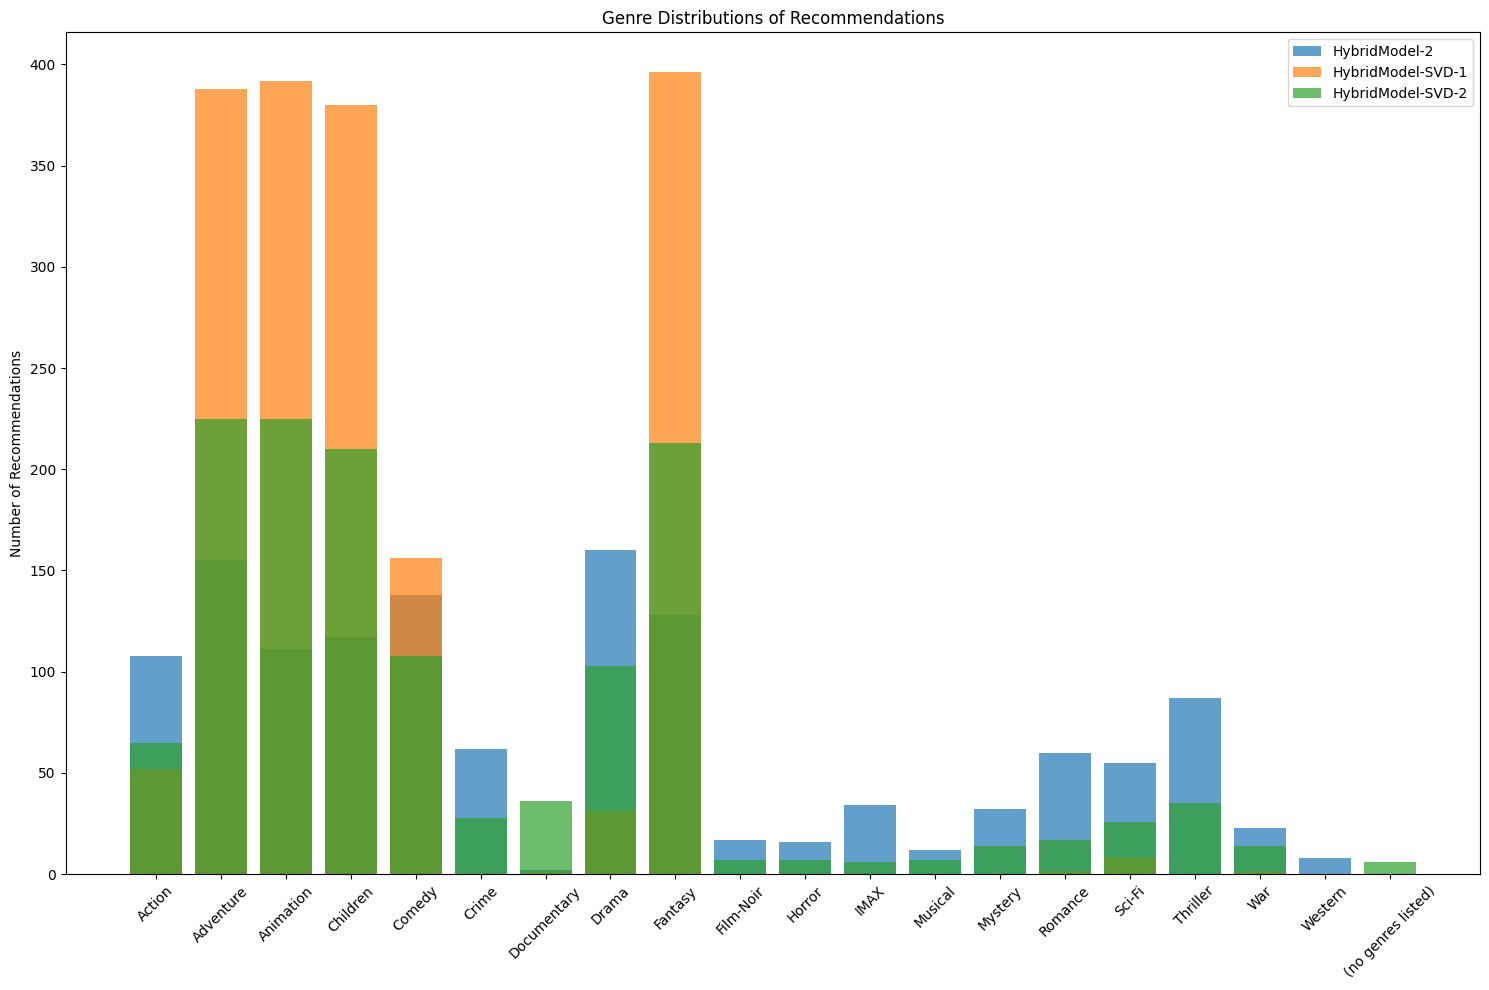

In [49]:
def get_genre_distribution(recommendations, movies):
    genre_counts = defaultdict(int)
    
    for user_id, user_recommendations in recommendations.items():
        if 'movieId' in user_recommendations:
            recommended_genres = movies[movies['movieId'].isin(user_recommendations['movieId'])]['genres'].str.split('|').tolist()
            for genre_list in recommended_genres:
                for genre in genre_list:
                    genre_counts[genre] += 1

    return genre_counts


def plot_genre_distributions(models, movies, user_ids_sample, movie_title_sample):
    plt.figure(figsize=(15, 10))
    
    for model_name, model_instance in models.items():
        recs = generate_recommendations(model_instance, user_ids_sample, movie_title_sample)
        genre_distribution = get_genre_distribution(recs, movies)

        sorted_genres = sorted(genre_distribution.keys())
        counts = [genre_distribution[genre] for genre in sorted_genres]
        
        plt.bar(sorted_genres, counts, label=model_name, alpha=0.7)
        
    plt.xticks(rotation=45)
    plt.ylabel('Number of Recommendations')
    plt.title('Genre Distributions of Recommendations')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_genre_distributions(models, movies, user_ids_sample, movie_title_sample)

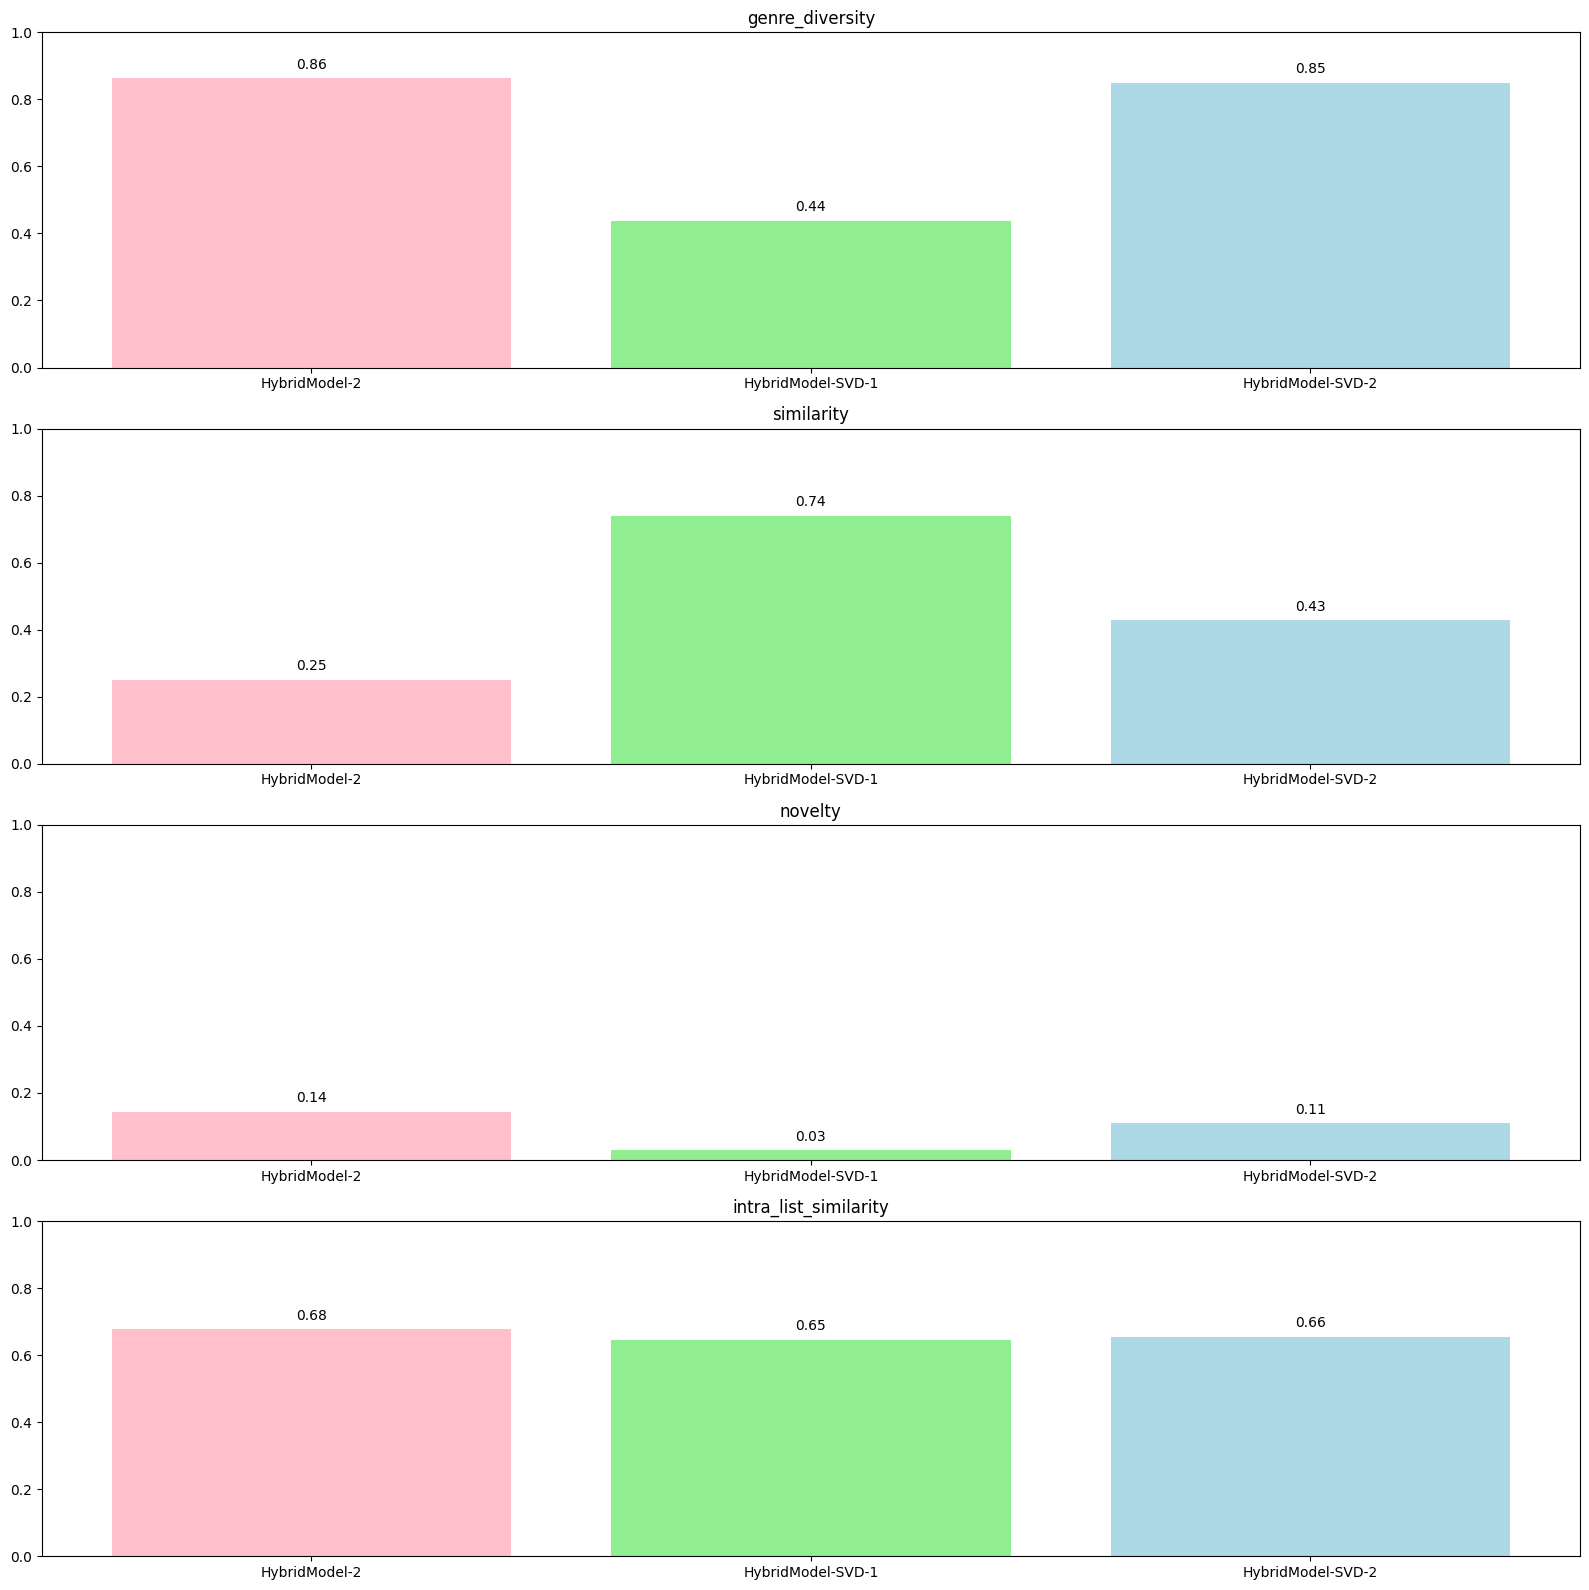

In [50]:
fig, ax = plt.subplots(4, 1, figsize=(16, 16))
colors = ['pink', 'lightgreen', 'lightblue']

for i, column in enumerate(results.columns):
    ax[i].bar(results.index, results[column], color=colors)
    ax[i].set_title(column)
    ax[i].set_ylim(0, 1) 
    for j, v in enumerate(results[column]):
        ax[i].text(j, v + 0.02, "{:.2f}".format(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [57]:
weights = {
    'genre_diversity': 0.60,
    'similarity': 0.50,
    'novelty': 0.30,
    'intra_list_similarity': -0.40
}

models = ['HybridModel-2', 'HybridModel-SVD-1', 'HybridModel-SVD-2']
overall_scores = {}

for model in models:
    score = sum(results.loc[model, metric] * weight for metric, weight in weights.items())
    overall_scores[model] = score

print(overall_scores)


{'HybridModel-2': 0.41532166457739955, 'HybridModel-SVD-1': 0.3824039815456871, 'HybridModel-SVD-2': 0.49471913064328665}


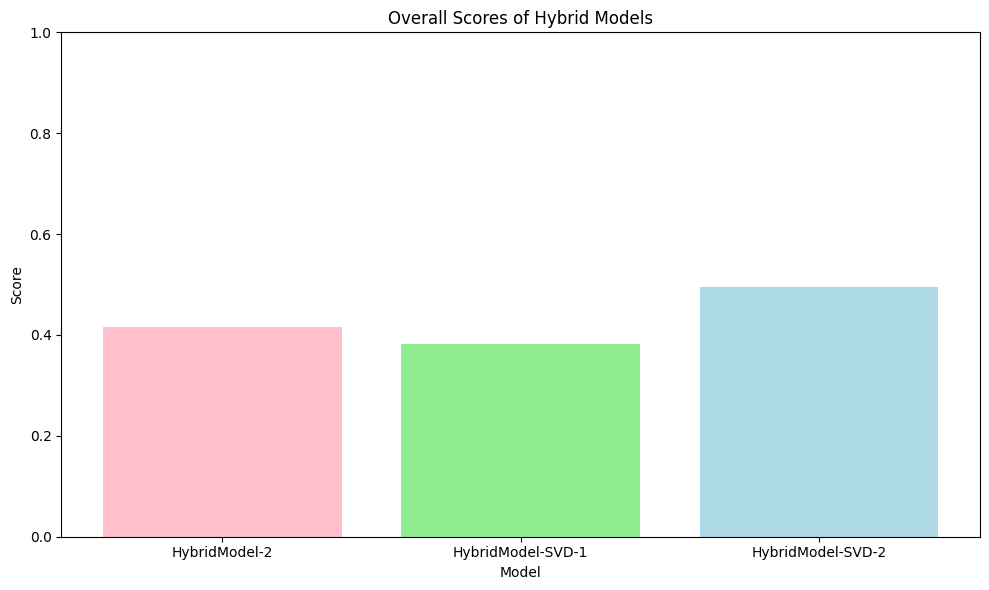

In [59]:
models = list(overall_scores.keys())
scores = list(overall_scores.values())

plt.figure(figsize=(10, 6))
plt.bar(models, scores, color=['pink', 'lightgreen', 'lightblue'])

plt.title('Overall Scores of Hybrid Models')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)  

plt.tight_layout()
plt.show()